In [3]:
import clip
import pandas as pd
import torch
import torch.utils.data
import torchvision.transforms as T
from PIL import Image
from torchmultimodal.models.mdetr.model import mdetr_for_phrase_grounding
from torchvision.ops import box_iou
from torchvision.ops.boxes import box_convert
from transformers import RobertaTokenizerFast

from modules.refcocog import RefCOCOg, RefCOCOgSample
from modules.utilities import display_preds


In [2]:
#@title Set correct device

if torch.cuda.is_available():
    device = torch.device("cuda")  # CUDA GPU
    print("[INFO] Using GPU.")
elif torch.has_mps:
    device = torch.device("mps")  # Apple Silicon GPU
    print("[INFO] Using MPS.")
else:
    device = torch.device("cpu")
    print("[INFO] No GPU found, using CPU instead.")


[INFO] Using MPS.


In [3]:
#@title Import RefCOCOg dataset and its train/val/test splits

data_path = "dataset/refcocog"

dataset = RefCOCOg(ds_path=data_path)

train_ds = RefCOCOg(ds_path=data_path, split='train')
val_ds = RefCOCOg(ds_path=data_path, split='val')
test_ds = RefCOCOg(ds_path=data_path, split='test')

print(f"[INFO] Dataset Size: {len(dataset)}")
print(f"[INFO] train split:  {len(train_ds)}")
print(f"[INFO] val split:    {len(val_ds)}")
print(f"[INFO] test split:   {len(test_ds)}")


[INFO] Dataset Size: 49822
[INFO] train split:  42226
[INFO] val split:    2573
[INFO] test split:   5023


In [6]:


medtr_cpt_url = "https://pytorch.s3.amazonaws.com/models/multimodal/mdetr/pretrained_resnet101_checkpoint.pth"


def rescale_boxes(boxes, size):
    """
    Util to rescale predicted boxes to match image size

    """

    w, h = size
    b = box_convert(boxes, "cxcywh", "xyxy")
    b = b * torch.tensor([w, h, w, h], dtype=torch.float32)
    return b


class MDETR:

    def __init__(self, device="cpu", quiet=True):
        super().__init__()
        self.MDETR = mdetr_for_phrase_grounding()
        self.MDETR.load_state_dict(torch.hub.load_state_dict_from_url(medtr_cpt_url)["model_ema"])
        self.RoBERTa = RobertaTokenizerFast.from_pretrained("roberta-base")
        self.quiet = quiet
        self.device = device
        self.img_preproc = T.Compose([
            T.Resize(800),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __call__(self, img_sample, prompt, show=True):
        # 1. Encode the prompt with RoBERTa

        img = Image.open(img_sample.path)

        enc_text = self.RoBERTa.batch_encode_plus([prompt], padding="longest", return_tensors="pt")["input_ids"]

        # 2. Preprocess the image and run MDETR on image and prompt

        img_transformed = self.img_preproc(img)

        with torch.no_grad():
            out = self.MDETR([img_transformed], enc_text).model_output

        probs = 1 - out.pred_logits.softmax(-1)[0, :, -1]

        boxes_scaled = rescale_boxes(out.pred_boxes[0, :], img.size)

        mdetr_results = pd.DataFrame(boxes_scaled.squeeze().numpy().reshape(-1, 4))
        mdetr_results.columns = ["xmin", "ymin", "xmax", "ymax"]
        mdetr_results["prob"] = probs.numpy()

        mdetr_results = mdetr_results.sort_values(by=['prob'], ascending=False)

        pred_bbox = mdetr_results.iloc[0, :4].tolist()
        best_prob = mdetr_results.iloc[0, 4]
        gt_bbox = img_sample.bbox

        # Compute IoU

        iou = box_iou(
            torch.tensor(pred_bbox).unsqueeze(0),
            torch.tensor(gt_bbox).unsqueeze(0)
        ).item()

        display_preds(img, prompt, pred_bbox, gt_bbox, "MDETR")

        return iou



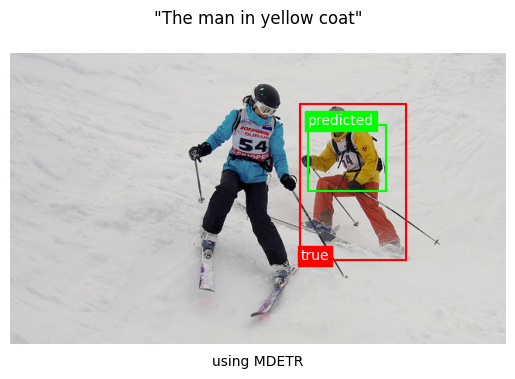

0.31003445386886597

In [162]:
m = MDETR(device=device)

sample = dataset[0]
sample = RefCOCOgSample(**sample)

m(sample, sample.sentences[0])


---

In [11]:
MDETR = mdetr_for_phrase_grounding()



In [21]:
mt_enc = MDETR.model.transformer.encoder

mt_enc

TransformerEncoder(
  (layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (mlp): MLP(
        (model): Sequential(
          (0): Linear(in_features=256, out_features=2048, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=2048, out_features=256, bias=True)
        )
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

---

In [41]:
class ClipEncoder:

    def __init__(self, clip_ver="ViT-L/14", device="cpu"):
        self.clip_model, self.clip_prep = clip.load(clip_ver, device=device)
        self.device = device

    def encode_text(self, text):
        text_ = clip.tokenize(text).to(self.device)

        with torch.no_grad():
            return self.clip_model.encode_text(text_)

    def encode_img(self, image):
        image_ = self.clip_prep(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            return self.clip_model.encode_image(image_)


clip_encoder = ClipEncoder(device=device)


[INFO] CLIP version: ViT-L/14


In [53]:
def collate_fn(data):
    sample = RefCOCOgSample(**data[0])

    return sample.bbox, sample.img, sample.sentences


dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)